<a href="https://colab.research.google.com/github/Wook0111/ChAiJum-Ajou-SW-Challenge-/blob/main/Classification_with_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install

In [1]:
!pip install tensorflow-probability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Set Up

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet152V2
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Training

In [23]:
def training(model, train_data, validation_data, optimizer, loss, epochs, saving_name) :

  checkpoint_path = saving_name + ".ckpt"
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  
  checkpoint = [
                EarlyStopping(patience=3, restore_best_weights=True),
                ModelCheckpoint(filepath=checkpoint_path, 
                                save_best_only=True,  
                                verbose=1)
  ]
  
  history = model.fit(train_data,
            validation_data=validation_data,
            epochs=epochs,
            callbacks=checkpoint,
            )


  return history

#Evaluate

In [24]:
def evaluate(model, test_data) :
  loss, acc = model.evaluate(test_data, verbose=2)
  print("test loss: %f, test accuracy: %f" %(loss, acc*100))

#Data Set

Image preprocessing

In [25]:
TRAINING_DIR = '/content/drive/Shareddrives/dall_e/Picture/Train_data/'
TEST_DIR = '/content/drive/Shareddrives/dall_e/Picture/Test_data/'

In [26]:
BATCH_SIZE = 32
training_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='reflect',
        vertical_flip=False,
        validation_split=0.2
        )

training_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                          target_size=(128,128),     
                                                          batch_size=BATCH_SIZE,
                                                          shuffle = False,
                                                          class_mode='categorical',
                                                          subset = 'training')

validation_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                            target_size=(128,128),        
                                                            batch_size=BATCH_SIZE,
                                                            shuffle = False,
                                                            class_mode='categorical',
                                                            subset = 'validation')



test_datagen = ImageDataGenerator(
        rescale=1. / 255
        )


test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  classes = ['Bull_test', 'Sheep_test', 'Cat_test', 'Dog_test', 'Horse_test'], 
                                                  batch_size=1, 
                                                  target_size=(128, 128),
                                                  shuffle = False, 
                                                  class_mode='categorical'
                                                  )


Found 5120 images belonging to 5 classes.
Found 1280 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.


#**Experiment 3**-BNN
(Using DALL-E Dataset)

##Model

In [27]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [28]:
HIDDEN_UNITS = [128]
OUTPUT_HIDDEN_UNITS = [5]

def create_BNN_model():
    inputs = layers.Input(shape=(128, 128,3),dtype=tf.float32)
    features = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2, activation='relu')(inputs)
    features = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2, activation='relu')(features)
    features = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2, activation='relu')(features)
    #features = layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu',name = 'Input')(inputs)
    #features = layers.AveragePooling2D(2, 2, name='maxp1')(features)
    #features = layers.Conv2D(64, (3, 3), activation='relu',name = 'Conv1')(features)
    #features = layers.AveragePooling2D(2, 2, name='maxp2')(features)
    #features = layers.Conv2D(64, (3, 3), activation='relu',name = 'Conv2')(features)
    
    #features = layers.AveragePooling2D(2, 2, name='maxp3')(features)
    #features = layers.Conv2D(128, (3, 3), activation='relu',name = 'Conv3')(features)
    #features = layers.AveragePooling2D(2, 2, name='maxp4')(features)
    #features = layers.Conv2D(32, (3, 3), activation='relu',name = 'Conv4')(features)
    #features = layers.AveragePooling2D(2, 2, name='maxp5')(features)
    features = layers.Flatten(name='Flatten')(features)
    features = layers.BatchNormalization()(features)
    #features = tf.keras.layers.Dense(128, activation='relu')(features)
    #features = tfp.layers.DenseFlipout(64, activation=tf.nn.relu)(features)
    #features = tfp.layers.DenseLocalReparameterization(64, activation=tf.nn.relu)(features)
    #features = tfp.layers.DenseReparameterization(64, activation=tf.nn.relu)(features)
    
    #features = tf.keras.layers.Dense(5, activation='softmax')(features)
    features = tfp.layers.DenseFlipout(128, activation=tf.nn.relu)(features)
    features = tfp.layers.DenseFlipout(8, activation=tf.nn.relu)(features)
    features = tfp.layers.DenseFlipout(5, activation='softmax')(features)
#    features = layers.Dense(128, activation='relu',name = 'FC1')(features)
    


    # Create hidden layers with weight uncertainty using the DenseVariational layer.
#    for units in hidden_units:
#        features = tfp.layers.DenseVariational(
#            units=units,
#            make_prior_fn=prior,
#            make_posterior_fn=posterior,
#            kl_weight=1 / 32,
#            activation="relu",
#        )(features)
#    features = layers.Dense(8, activation='relu',name = 'FC2')(features)
#    for units in output_hidden_units:
#        features = tfp.layers.DenseVariational(
#            units=units,
#            make_prior_fn=prior,
#            make_posterior_fn=posterior,
#            kl_weight=1 / 32,
#            activation="softmax",
#        )(features)
    # The output is deterministic: a single point estimate.
    #outputs = layers.Dense(units=5, activation = 'softmax')(features)
    model = keras.Model(inputs=inputs, outputs=features)
    return model

##Run

In [29]:
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
EPOCHS = 10
SAVING_NAME = 'model_BNN'

model_BNN = create_BNN_model()
model_BNN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_flipout_6 (Conv2DFli  (None, 64, 64, 32)       1760      
 pout)                                                           
                                                                 
 conv2d_flipout_7 (Conv2DFli  (None, 32, 32, 64)       36928     
 pout)                                                           
                                                                 
 conv2d_flipout_8 (Conv2DFli  (None, 16, 16, 32)       36896     
 pout)                                                           
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                           

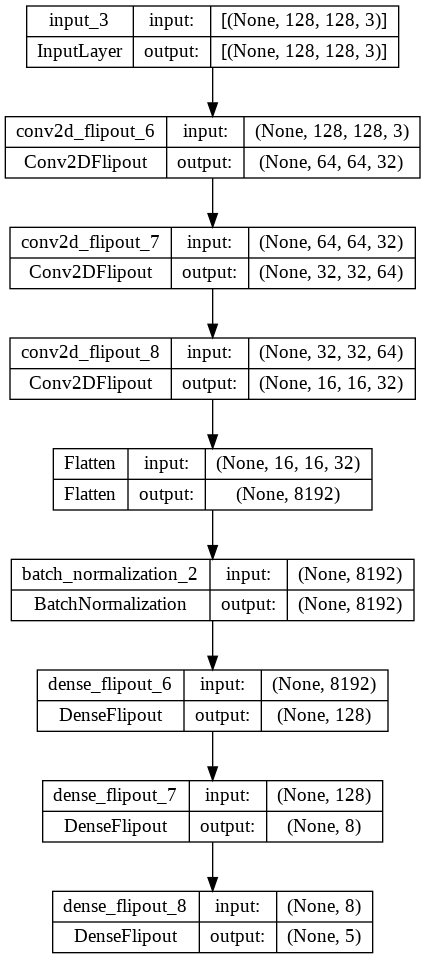

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model_BNN, show_shapes=True)

In [31]:
history_BNN= training(model_BNN, training_generator, validation_generator, OPTIMIZER, LOSS, EPOCHS, SAVING_NAME)

Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 2664481.5000 - accuracy: 0.2021 
Epoch 1: val_loss improved from inf to 2578109.50000, saving model to model_BNN.ckpt
160/160 [==============================] - 2717s 17s/step - loss: 2664481.5000 - accuracy: 0.2021 - val_loss: 2578109.5000 - val_accuracy: 0.1828
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 2494504.2500 - accuracy: 0.1986
Epoch 2: val_loss improved from 2578109.50000 to 2410242.50000, saving model to model_BNN.ckpt
160/160 [==============================] - 84s 525ms/step - loss: 2494504.2500 - accuracy: 0.1986 - val_loss: 2410242.5000 - val_accuracy: 0.2000
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 2327662.5000 - accuracy: 0.1910
Epoch 3: val_loss improved from 2410242.50000 to 2244349.25000, saving model to model_BNN.ckpt
160/160 [==============================] - 85s 528ms/step - loss: 2327662.5000 - accuracy: 0.1910 - val_loss: 2244349.2500 - v

##Visualization

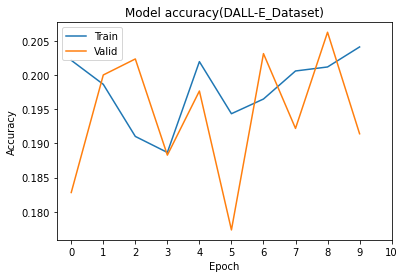

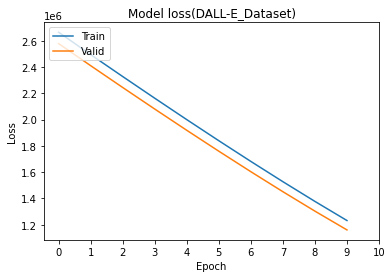

In [32]:
import matplotlib.pyplot as plt

plt.plot(history_BNN.history['accuracy'])
plt.plot(history_BNN.history['val_accuracy'])
plt.title('Model accuracy(DALL-E_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history_BNN.history['loss'])
plt.plot(history_BNN.history['val_loss'])
plt.title('Model loss(DALL-E_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Evaluation

In [33]:
model_BNN = load_model('/content/'+SAVING_NAME+'.ckpt')

In [34]:
evaluate(model_BNN, test_generator)

1600/1600 - 994s - loss: 1160966.7500 - accuracy: 0.1956 - 994s/epoch - 621ms/step
test loss: 1160966.750000, test accuracy: 19.562501
